In [44]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
import healpy as hp


fname="/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-0/jura-0/raw/deltas_lya/Delta/delta-100.fits.gz" 
delta_F = fits.open(fname)

# grab all objects in this file:
nobj = len(delta_F)-1
print(f"{nobj} objects to go through...")

emit = 1215.67 # Ly-alpha wavelength

# min and max of the forest of A region (we do not take B region bc of Ly-beta absorption)
lambda_rf_min=1040
lambda_rf_max=1200

for jj in range(1): # there can be mutliple quasars in one object
    wavelength_log = delta_F[jj+1].data['LOGLAM']
    delta_l = delta_F[jj+1].data['DELTA']
    weight_l = delta_F[jj+1].data['WEIGHT']
    #cont_l = delta_F[1].data['CONT']

    # for each, bin in redshift: 
    wave = 10**wavelength_log
    objred = (wave-emit)/emit

    hduh = delta_F[jj+1].header
    # converting coordinates from radians to degrees
    ra = hduh['RA']*180/np.pi
    dec = hduh['DEC']*180/np.pi
    zqso = hduh['Z']
    
    # select pixels in forest
    lambda_obs_min=lambda_rf_min*(1+zqso)
    lambda_obs_max=lambda_rf_max*(1+zqso)
    in_forest=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)

916 objects to go through...


### Plot the flux contrast δF across wavelength
Shows the fluctuations of one forest fluctuations

/tmp/ipykernel_1864566/121422252.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


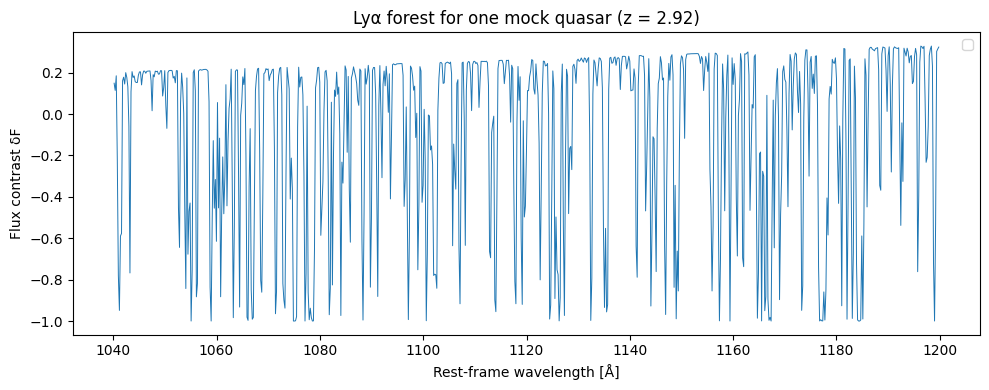

In [45]:

plt.figure(figsize=(10,4))
plt.plot(wave[in_forest]/(1+zqso), delta_l[in_forest], lw=0.7)
plt.xlabel("Rest-frame wavelength [Å]")
plt.ylabel("Flux contrast δF")
plt.title(f"Lyα forest for one mock quasar (z = {zqso:.2f})")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
for jj in range(nobj): # there can be mutliple quasars in one object
    wavelength_log = delta_F[jj+1].data['LOGLAM']
    delta_l = delta_F[jj+1].data['DELTA']
    weight_l = delta_F[jj+1].data['WEIGHT']
    #cont_l = delta_F[1].data['CONT']

    # for each, bin in redshift: 
    wave = 10**wavelength_log
    objred = (wave-emit)/emit

    hduh = delta_F[jj+1].header
    ra = hduh['RA']*180/np.pi
    dec = hduh['DEC']*180/np.pi
    zqso = hduh['Z']
    
    # select pixels in forest
    lambda_obs_min=lambda_rf_min*(1+zqso)
    lambda_obs_max=lambda_rf_max*(1+zqso)
    in_forest=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)

Collected 916 quasars with RA, Dec, z_qso
Approximate resolution at NSIDE 64 is 0.92 deg


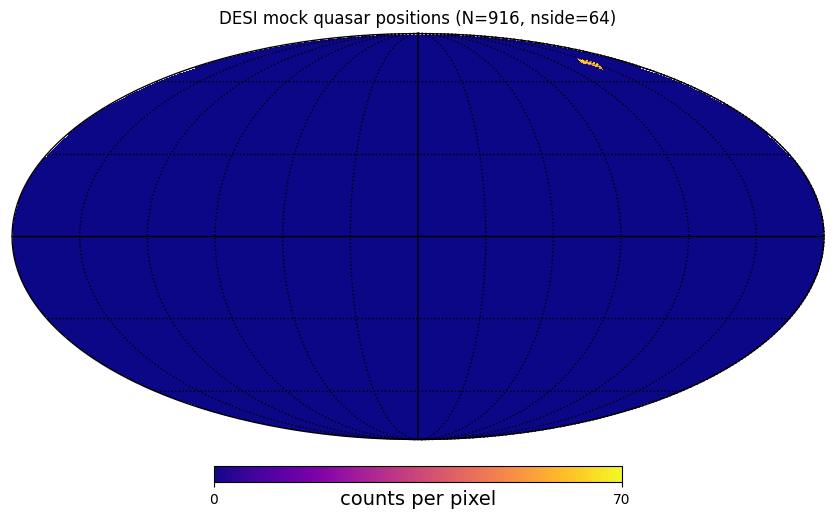

In [54]:
ras, decs, zqsos = [], [], []

for jj in range(nobj):
    hduh = delta_F[jj+1].header
    ra = hduh["RA"] * 180/np.pi
    dec = hduh["DEC"] * 180/np.pi
    zqso = hduh["Z"]

    ras.append(ra)
    decs.append(dec)
    zqsos.append(zqso)

delta_F.close()

ras = np.array(ras)
decs = np.array(decs)
zqsos = np.array(zqsos)

print(f"Collected {len(ras)} quasars with RA, Dec, z_qso")


# Make HEALPix map
nside = 64  # resolution (higher = finer)
print("Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60))


npix = hp.nside2npix(nside)
m = np.zeros(npix)

# convert to HEALPix coordinates (theta = colatitude, phi = longitude)
theta = np.radians(90.0 - decs)  # colatitude
phi = np.radians(ras)            # longitude
pix = hp.ang2pix(nside, theta, phi)

# fill map with counts
for p in pix:
    m[p] += 1


hp.mollview(
    m,
    title=f"DESI mock quasar positions (N={len(ras)}, nside={nside})",
    unit="counts per pixel",
    cmap="plasma"
)
hp.graticule()
plt.show()



In [7]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
import healpy as hp
import picca
import treecorr
import pylab as pl
import shutil


In [37]:

home_dir = os.path.expanduser('~')
savedir = os.path.join(home_dir, 'PhD', 'test/')
print(savedir)

/global/homes/o/otilia/PhD/test/


In [65]:
#filename = "/global/homes/o/otilia/PhD/test/delta-raw.fits"
fname="/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-0/jura-0/raw/deltas_lya/Delta/delta-100.fits.gz" 

cat = fits.open(filename)
cat[1].columns


ColDefs(
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'Z'; format = 'D'
    name = 'ZQSO'; format = 'D'
    name = 'DELTA_F'; format = 'D'
    name = 'DELTA_F_WEIGHTED'; format = 'D'
    name = 'NPIX'; format = 'D'
    name = 'TOTWEIGHTS'; format = 'D'
)

In [66]:

set_params=0

# below are a few configurations, you can change to your own
if set_params==0:
    njn=64
    theta_min=1
    theta_max=20
    unit='arcmin'
    folder = "test-njn-64-noscale-1-20-arcm/"
    
elif set_params==1:
    njn=128
    theta_min=1
    theta_max=20
    unit='arcmin'
    folder = "test-njn-128-noscale-1-20-arcm/"
    
elif set_params==3:
    njn=64
    theta_min=1
    theta_max=10
    unit='arcmin'
    folder = "test-njn-64-noscale-1-10-arcm/"


#zsampf = np.loadtxt('/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt')
#edges = zsampf[:,0]
#zsamp = zsampf[:-1,1]
Nbins=40
edges = np.linspace(2,3,Nbins)
zsamp = (edges[1:] + edges[:-1])/2.

#galaxy = treecorr.Catalog(file_name="/pscratch/sd/q/qhang/desi-lya/photometry-catalogue-overlap-zmin-1.8.fits",
#                          ra_col='RA', dec_col='DEC',
#                          ra_units='deg', dec_units='deg', 
#                          npatch=njn,
#                         )



#fname = "delta-raw.fits" # or other delta file names
#cat = fits.open(fname)
z = cat[1].data['Z']

#nk = treecorr.NKCorrelation(min_sep=theta_min, max_sep=theta_max, nbins=1, sep_units=unit,
#                                   bin_slop=0, var_method='jackknife')

kk = treecorr.KKCorrelation(min_sep=theta_min, max_sep=theta_max, nbins=1, sep_units=unit,
                                   bin_slop=0, var_method='jackknife')

#res_holder_nk = np.zeros((len(edges)-1,2))
res_holder_kk = np.zeros((len(edges)-1,2))
#res_holder_ncc = np.zeros((len(edges)-1,2))

# columns: (xi, npairs, patch1, patch2)
for ii in range(len(edges)-1):
    
    sel = (z>=edges[ii])&(z<edges[ii+1])
    
    if len(z[sel])>0:
        
        print(f"Working on z slice {ii}")
        
        deltaF = treecorr.Catalog(
                          ra=cat[1].data['RA'][sel], dec=cat[1].data['DEC'][sel],
                          ra_units='deg', dec_units='deg', 
                          k=cat[1].data['DELTA_F'][sel], # if not raw, use DELTAF_WEIGHTED
                          w=cat[1].data['NPIX'][sel], # if no raw, use TOTWEIGHTS
                          #patch_centers=galaxy.patch_centers,
                          npatch=njn,
                         )
        
        #nk.process(galaxy,deltaF)
        kk.process(deltaF)
        
        #res_holder_nk[ii,0] = nk.raw_xi[0]
        #res_holder_nk[ii,1] = np.sqrt(nk.raw_varxi[0])
        
        res_holder_kk[ii,0] = kk.xi[0]
        res_holder_kk[ii,1] = np.sqrt(kk.varxi[0])
        
        #func = lambda corrs: corrs[0].raw_xi / np.sqrt(corrs[1].xi)
        #corrs = [nk, kk]
        #ratio = func(corrs)
        #cov = treecorr.estimate_multi_cov(corrs, method='jackknife', func=func)
        #res_holder_ncc[ii,0] = ratio[0]
        #res_holder_ncc[ii,1] = np.sqrt(cov[0,0])
           
# save the results - njn samples and std etc.
#np.savetxt(savedir + folder + "treecorr_nk.txt", res_holder_nk)
np.savetxt(savedir + folder + "treecorr_kk.txt", res_holder_kk)
#np.savetxt(savedir + folder + "treecorr_ncc.txt", res_holder_ncc)


Working on z slice 0
Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='match'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.
Working on z slice 1
Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='match'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.
Working on z slice 2
Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='match'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.
Working on z slice 3
Using the default cross_patch_weight='simple' may be less accurate than using cros

In [67]:
!pwd

/global/u1/o/otilia/PhD


In [68]:
corr = "test/test-njn-64-noscale-1-20-arcm/treecorr_kk.txt"
res_holder_kk = np.loadtxt(corr)



In [69]:
print(res_holder_kk[:, 0])

[0.00079287 0.00079881 0.00082465 0.00088849 0.00088953 0.00089618
 0.00094962 0.0010204  0.00104011 0.00109223 0.00111554 0.0011183
 0.00113274 0.00118754 0.00125638 0.00131671 0.00139629 0.00139128
 0.00144065 0.00083366 0.00162461 0.00162116 0.00181437 0.00178028
 0.00190775 0.00193905 0.00199211 0.00198211 0.00212092 0.00222066
 0.00228663 0.00229412 0.00250466 0.00324607 0.00237522 0.00389348
 0.01354101 0.         0.        ]


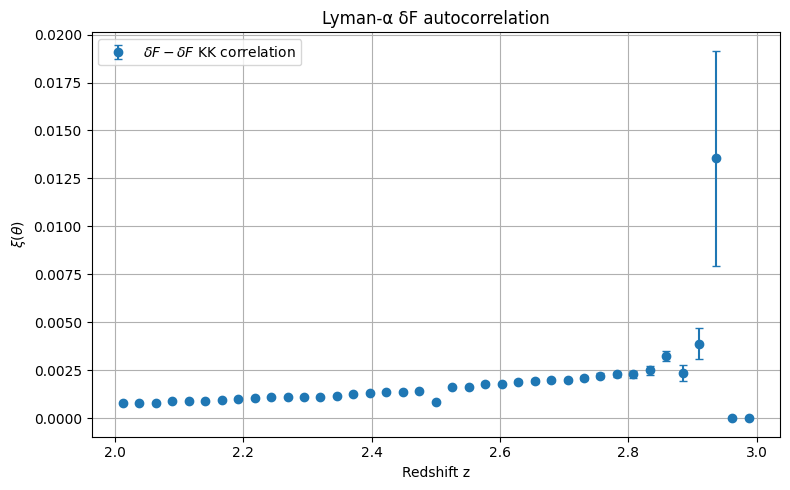

In [70]:
# xi = correlation values
xi = res_holder_kk[:,0]

# errors
xi_err = res_holder_kk[:,1]

# redshift bin centers
zcenters = zsamp

# Plot
plt.figure(figsize=(8,5))
plt.errorbar(zcenters, xi, yerr=xi_err, fmt='o', capsize=3, label=r'$\delta F - \delta F$ KK correlation')
plt.xlabel("Redshift z")
plt.ylabel(r"$\xi(\theta)$")
plt.title("Lyman-α δF autocorrelation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='match'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.


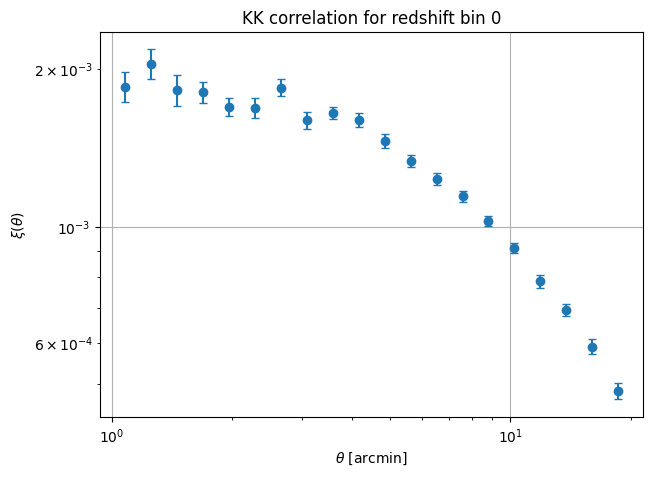

In [71]:
cat = fits.open(filename)

z = cat[1].data['Z']


# Select redshift bin 0
edges = np.linspace(2,3,40)  # same as before
sel = (z >= edges[0]) & (z < edges[1])

deltaF = treecorr.Catalog(
    ra=cat[1].data['RA'][sel], 
    dec=cat[1].data['DEC'][sel],
    ra_units='deg', dec_units='deg', 
    k=cat[1].data['DELTA_F'][sel],
    w=cat[1].data['NPIX'][sel],
    npatch=64
)

# Set up KKCorrelation with multiple θ bins
kk = treecorr.KKCorrelation(
    min_sep=1, max_sep=20, nbins=20, sep_units='arcmin',
    bin_slop=0, var_method='jackknife'
)

kk.process(deltaF)

# Plot
theta = np.exp(kk.meanlogr)  # θ in arcmin
xi = kk.xi
xi_err = np.sqrt(kk.varxi)

plt.figure(figsize=(7,5))
plt.errorbar(theta, xi, yerr=xi_err, fmt='o', capsize=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\xi(\theta)$')
plt.title('KK correlation for redshift bin 0')
plt.grid(True)
plt.show()
